In [1]:
# # Install required packages (NB: they may already be installed on your machine)
# install.packages("tidyverse")
# install.packages("infer")
# install.packages("janitor")
# install.packages("repr")
# install.packages("stringr")
# install.packages("waffle", repos = "https://cinc.rud.is")
# install.packages("plyr")
# install.packages("ggthemes")

# # Waffle is sometimes finicky, so you might also need this to run this notebook locally
# remotes::install_github("hrbrmstr/waffle")

In [2]:
# Load required packages
library(plyr)
library(tidyverse)
library(infer)
library(janitor)
library(repr)
library(stringr)
library(waffle)
library(ggthemes)

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts -------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::arrange()   masks plyr::arrange()
x purrr::compact()   masks plyr::compact()
x dplyr::count()     masks plyr::count()
x dplyr::failwith()  masks plyr::failwith()
x dplyr::filter()    masks stats::filter()
x dplyr::id()        masks plyr::id()
x dplyr::lag()       masks stats::lag()
x dplyr::mutate()    masks plyr::mutate()
x dplyr::rename()    masks plyr::rename()
x dplyr::summarise() masks plyr::summarise()
x dplyr::summarize() masks plyr::summarize()


Attaching package: 'janitor'


The following objects

In [3]:
# Custom ggplot theme for use throughout the analysis
# Idea from [Joey Stanley](https://joeystanley.com/blog/custom-themes-in-ggplot2)

theme_stat201 <- function (width = 12, height = 5) { 
    options(repr.plot.width = width, repr.plot.height = height)
    theme_bw(base_size = 14) %+replace% 
        theme(
            plot.title = element_text(hjust = 0.5) 
        )
}

In [4]:
# A helper function to generate figure numbers
# TODO: figure out how to make figure_number increment correctly
create_caption <- function (figure_number, title) {
    print(paste(sprintf("Figure #%d:", figure_number), title))
}
create_caption(0, "Hello, world!")

[1] "Figure #0: Hello, world!"


# Examining the Impact of COVID-19 on the Proportion of Theft-Related Crimes in Vancouver

**Authors** Group 4, Project Proposal (Acky Xu, Adam Mitha, Icy Xu, Michael DeMarco)

**Abstract** This project looks at the impact of the COVID-19 pandemic on theft-related crime in select Vancouver neighborhoods. Novel inferential techniques are applied to estimate the proportion of theft crime relative to all crime between now (2020) and the mean proportion of the past 3 years (2017 to 2019). Our findings are still to be  determined, and will be included in the final report.

<p style="display: block; text-align: center;">
    <img style="display: block; margin: 0 auto;" src="./vpd.jpg" alt="A VPD car" width="50%" />
</p>

<p style="text-align: center;"><i>A Vancouver Police Department (VPD) car.</i></p>

## Introduction

### Background 

Since the beginning of the COVID-19 pandemic in March of 2020, many have discussed the issue of alleged increasing crime rates both globally and within Metro Vancouver. Indeed, an unprecedented economic contraction [[Statistics Canada, 1]](https://www150.statcan.gc.ca/n1/pub/11-631-x/2020004/conclusions-eng.htm) coupled with fewer resources, such as shelters or food banks, has driven an increase in many types of crime, including in fraud and counterfeiting crime [[Interpol, 2]](https://www.interpol.int/en/News-and-Events/News/2019/Operation-Pangea-shining-a-light-on-pharmaceutical-crime), hate crimes [[ABC News, 3]](https://abcnews.go.com/US/fbi-warns-potential-surge-hate-crimes-asian-americans/story?id=69831920)—with those of East Asian descent being impacted most significantly—and domestic violence [[UN News, 4]](https://news.un.org/en/story/2020/04/1061052).

These spikes have led to tension between municipal governments and police departments with respect to budgeting in the wake of the economic depravity of the COVID-19 era. The City of Vancouver, specifically, enacted a freeze on the police budget in 2021 [[CBC, 5]](https://www.cbc.ca/news/canada/british-columbia/city-of-vancouver-freezes-police-department-funding-as-part-of-2021-budget-1.5833731).

Existing literature has primarily focused on many types of "global" crime (e.g., organized crime, terrorist attacks), and has largely concluded that on the whole, these types of crimes are increasing through the pandemic year; in our analysis, we'll look closely at "petty" crimes, specifically theft, and see how, if at all, the rate of theft crime has changed amidst the pandemic. We choose three neighborhoods—Strathcona, Marpole, and Shaughnessy—for our analysis. Per the City of Vancouver's 2016 local area profiles, these are the "average total incomes among residents"  in those three neighborhoods [[City of Vancouver, 9]](https://opendata.vancouver.ca/explore/dataset/census-local-area-profiles-2016/information/):

* Shaughnessy, \$118,668
* Marpole, \$39,020
* Strathcona, \$31,534

(We can use the City of Vancouver's local profiles as they match the VPD's neighborhood classifications.) Thus, we have the "upper class," "middle class," and "lower class" represented by each neighborhood respectively.

### Question

We are interested in exploring how much, if at all, the proportion of petty crime rates have changed in Metro Vancouver over the last year. We will compare crime rates from 2017 to 2020 in neighborhoods characteristic of the full economic spectrum.

Therefore, our research question is as follows: _"How has the proportion of theft-related crime changed, if at all, in Vancouver during 2020, the year of the COVID-19 pandemic, when looked at across the full economic spectrum via three neighborhoods: Strathcona, Marpole, and Shaughnessy?"_

### Data set

We're considering our sample to be what is available in the Vancouver Police Department's database, and our population is _all_ actual crime that occurred in Vancouver, not just reported crime. Of course it is impossible to know how much crime actually occurred, but through our data set sample we'll be able to produce an estimate.

We will be using the Vancouver Police Department's Open Crime Data [[VPD, 6]](https://geodash.vpd.ca/opendata/) to answer our research question. In particular, we'll need three columns from the data set:

| Column | Description | Notes |
|-|-|-|
| Year | "A four-digit field that indicates the year when the reported crime activity" | We'll use data from 2017 to 2020. |
| Type | "The type of crime activities" | We're considering theft crime to be all crime types with "theft" explicitly in the name. |
| Neighborhood | "Neighborhoods within the City of Vancouver are based on the census tract (CT) concept within census metropolitan area (CMA)." | We'll take three neighborhoods, representing the full economic spectrum. |

Our random variable of interest is the difference in the proportion of theft-related crime with respect to all crime through COVID. Given our population is all Vancouver crime, our parameter of interest is the difference in the proportion of theft related crime from the last three years (2017 to 2019) to now (2020).

We will be studying the change of this value from 2017 to 2020 across three different Vancouver neighborhoods, each characteristic of a different level of wealth. Thus, our location parameter is a proportion with an error reported by its standard error, which can be computed via bootstrapping, asymptotics, or mathematically, with the formula:

$$ {SE}_{\hat{p}_1 - \hat{p}_2} = \sqrt(\frac{\hat{p}_1\hat{q}_1}{n_1} + \frac{\hat{p}_2\hat{q}_2}{n_2}) $$

where

$$ p_i = 1 - q_i $$

We will also look at creating a confidence interval for the standard deviation of our proportion estimate as well, but this won't be the focus of our analysis [[Piazza, 7]](https://piazza.com/class/kjqe81ynudx2rm?cid=169). 

## Preliminary Results

We'll start by importing the dataset from it's original source [[VPD, 6]](https://geodash.vpd.ca/opendata), loading it into a dataframe and inspecting the results.

In [5]:
# Download the file to wherever your Jupyter notebook is located
url <- "https://geodash.vpd.ca/opendata/crimedata_download/crimedata_csv_all_years.zip"
filename <- "crime_data.zip"
download.file(url, destfile = filename)

# Data comes in as a zip, so we'll need to extract it
unzip("crime_data.zip")

# Read in the desired file
crime_data <- read_csv("crimedata_csv_all_years.csv")


-- Column specification ----------------------------------------------------------------------------------------------------------------------------------------------
cols(
  TYPE = col_character(),
  YEAR = col_double(),
  MONTH = col_double(),
  DAY = col_double(),
  HOUR = col_double(),
  MINUTE = col_double(),
  HUNDRED_BLOCK = col_character(),
  NEIGHBOURHOOD = col_character(),
  X = col_double(),
  Y = col_double()
)




In [6]:
# Inspect the first and last three rows of the data frame
head(crime_data, n = 3)
tail(crime_data, n = 3)

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2012,12,14,8,52,NA,Oakridge,491285.0,5453433
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Vehicle Collision or Pedestrian Struck (with Injury),2016,6,20,18,11,YUKON ST / W KING EDWARD AVE,Riley Park,491786,5455143
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,3,9,49,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,27,14,40,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126


Our data largely comes in a "tidy" format already. By tidy, we're verifying (from the DSCI 100 course textbook [[Data Science: A First Introduction, 12]](https://ubc-dsci.github.io/introduction-to-datascience/), verbatim, which in turn is from Wickham and others [[R for Data Science, 11]](https://r4ds.had.co.nz/)): 
> * each row is a single observation,
> * each column is a single variable, and
> * each value is a single cell

However, there are four steps we could take to improve the data set for our use: 
1. clean up the column names,
2. remove N/As,
3. select only data relevant to our analysis, and
4. convert crime types and neighborhoods to a factor, since we're working with proportions (i.e., categorical data).

We're primarily interested in the year, type and neighborhood of crimes, so we'll extract those columns and discard the rest. In addition, we would like to focus on the years 2017 to 2020.

In [25]:
# 1. Generally, in R, you don't see ALL CAPS column names,
# so we can modify the column names manually (with the help)
# of the janitor library
crime_data <- crime_data %>% clean_names()
head(crime_data)

type,year,neighbourhood
<fct>,<dbl>,<fct>
Break and Enter Commercial,2017,Strathcona
Break and Enter Commercial,2020,Strathcona
Break and Enter Commercial,2020,Strathcona
Break and Enter Commercial,2017,Strathcona
Break and Enter Commercial,2018,Strathcona
Break and Enter Commercial,2019,Strathcona


In [8]:
# 2. Remove all NAs (Note: na.omit(...) applies to the entire data frame, 
# but neighbourhood is used as an example)

total_rows <- crime_data %>% nrow()
print(sprintf("There are %d rows in the data frame", total_rows))

na_neighbourhoods <- sum(is.na(crime_data$neighbourhood))
print(sprintf("Originally, there were %d NA values in the neighbourhood column", na_neighbourhoods))

crime_data <- na.omit(crime_data)

na_neighbourhoods <- sum(is.na(crime_data$neighbourhood))
print(sprintf("Now, there are %d NA values in the neighbourhood column", na_neighbourhoods))

[1] "There are 666293 rows in the data frame"
[1] "Originally, there were 69872 NA values in the neighbourhood column"
[1] "Now, there are 0 NA values in the neighbourhood column"


In [9]:
# 3. Select only type, year, neighbourhood
# Filter to the date range of 2017-2020
crime_data <- crime_data %>% 
    select(type, year, neighbourhood) %>%
    filter(2017 <= year & year <= 2020)
head(crime_data)

type,year,neighbourhood
<chr>,<dbl>,<chr>
Break and Enter Commercial,2019,Fairview
Break and Enter Commercial,2019,West End
Break and Enter Commercial,2020,West End
Break and Enter Commercial,2017,West End
Break and Enter Commercial,2018,West End
Break and Enter Commercial,2020,West End


In [10]:
# 4. Now, we'll convert `neighbourhood` and `type` to a factor, 
# since we're considering it categorical data
crime_data <- crime_data %>%
    mutate(type = as_factor(type)) %>%
    mutate(neighbourhood = as_factor(neighbourhood))
head(crime_data)

type,year,neighbourhood
<fct>,<dbl>,<fct>
Break and Enter Commercial,2019,Fairview
Break and Enter Commercial,2019,West End
Break and Enter Commercial,2020,West End
Break and Enter Commercial,2017,West End
Break and Enter Commercial,2018,West End
Break and Enter Commercial,2020,West End


Next, let's see how many different types of crimes there are present in our data set.

In [11]:
# Grab all unique crime types, and print them in a pretty way
crime_types <- unique(crime_data$type)
print(crime_types)

[1] Break and Enter Commercial                            
[2] Break and Enter Residential/Other                     
[3] Mischief                                              
[4] Other Theft                                           
[5] Theft from Vehicle                                    
[6] Theft of Bicycle                                      
[7] Theft of Vehicle                                      
[8] Vehicle Collision or Pedestrian Struck (with Fatality)
[9] Vehicle Collision or Pedestrian Struck (with Injury)  
9 Levels: Break and Enter Commercial ... Vehicle Collision or Pedestrian Struck (with Injury)


As was mentioned in the introduction, we're interested in theft related crime. Let's create a list of all theft related crime we see in this data set.

In [12]:
theft_crimes <- c("Other Theft", "Theft from Vehicle", 
                  "Theft of Bicycle", "Theft of Vehicle")

We can also check the neighborhoods present in this data set.

In [13]:
# Grab all unique crime types, and print them in a pretty way
neighbourhoods <- unique(crime_data$neighbourhood)
print(neighbourhoods)

 [1] Fairview                  West End                 
 [3] Central Business District Hastings-Sunrise         
 [5] Strathcona                Grandview-Woodland       
 [7] Mount Pleasant            Sunset                   
 [9] Kensington-Cedar Cottage  Stanley Park             
[11] Shaughnessy               Marpole                  
[13] Oakridge                  Kitsilano                
[15] Victoria-Fraserview       Kerrisdale               
[17] West Point Grey           Riley Park               
[19] Arbutus Ridge             Renfrew-Collingwood      
[21] Killarney                 South Cambie             
[23] Dunbar-Southlands         Musqueam                 
24 Levels: Fairview West End Central Business District ... Musqueam


We chose three neighborhoods that we believe are representative of different economic classes present in Vancouver, in terms of median wealth: Shaughnessy, Strathcona, and Marpole. Let's save those as well.

In [14]:
chosen_neighbourhoods <- c("Shaughnessy", "Strathcona", "Marpole")

We're hoping to compare crime rates across years in neighborhoods that represent a reasonable distribution of incomes. For our proposal, we're going to be using the Shaughnessy, Strathcona, and Marpole neighborhoods. More on why these neighborhoods were chosen in particular is discussed in the "Methods" section.

In [15]:
# Filter down by the 3 neighbourhoods above
crime_data <- crime_data %>%
    filter(neighbourhood %in% chosen_neighbourhoods)

head(crime_data, n = 3)
tail(crime_data, n = 3)

type,year,neighbourhood
<fct>,<dbl>,<fct>
Break and Enter Commercial,2017,Strathcona
Break and Enter Commercial,2020,Strathcona
Break and Enter Commercial,2020,Strathcona


type,year,neighbourhood
<fct>,<dbl>,<fct>
Vehicle Collision or Pedestrian Struck (with Injury),2018,Strathcona
Vehicle Collision or Pedestrian Struck (with Injury),2018,Marpole
Vehicle Collision or Pedestrian Struck (with Injury),2018,Marpole


Now, to get a better sense of our data set, we'll produce three plots to explore, at a high level, what crime looks like in Vancouver both over time and by neighborhood. Our three plots will be:

1. A line plot of total crime over time, grouped by neighborhood; this will demonstrate the change in total crime over time
2. A stacked bar chart showing a breakdown of crime type, grouped by neighborhood; this will demonstrate the relative frequencies of each crime type, by neighborhood
3. A waffle plot to show to crime types proportions, grouped by year; this will demonstrate the relative frequencies of each crime type, by year

Let's begin with the line plot.

In [16]:
# To produce our line plot, first, we'll need to compute the total amount of crime
# by neighborhood and year
neighbourhood_year_counts <- crime_data %>%
    group_by(neighbourhood, year) %>% 
    summarise(n = n())
head(neighbourhood_year_counts)

`summarise()` has grouped output by 'neighbourhood'. You can override using the `.groups` argument.



neighbourhood,year,n
<fct>,<dbl>,<int>
Strathcona,2017,1772
Strathcona,2018,1986
Strathcona,2019,2168
Strathcona,2020,1708
Shaughnessy,2017,444
Shaughnessy,2018,414


[1] "Figure #1: A line plot depicting the number of total crimes over time by neighbourhood."


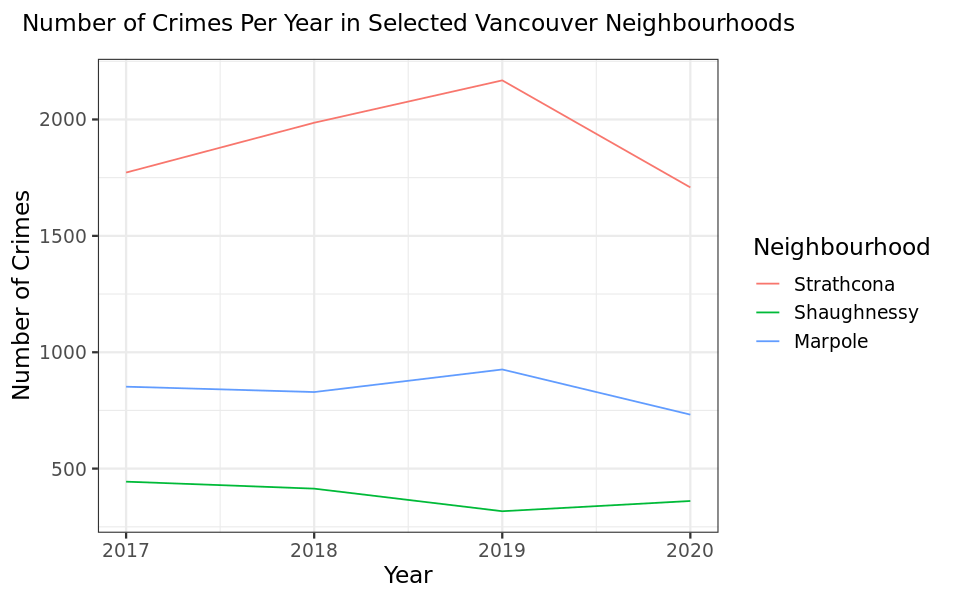

In [17]:
# 1. Finally, let's plot our data
crime_data_plot <- neighbourhood_year_counts %>%
    ggplot() +
    geom_line(aes(x = year, y = n, color = neighbourhood)) +
    scale_x_continuous(limits = c(2017, 2020)) +
    labs(x = "Year", y = "Number of Crimes", color = "Neighbourhood") +
    ggtitle("Number of Crimes Per Year in Selected Vancouver Neighbourhoods\n") +
    theme_stat201(8, 5)
crime_data_plot
create_caption(1, "A line plot depicting the number of total crimes over time by neighbourhood.")

It's clear that the crime is highest in Strathcona, followed by Marpole, and then Shaughnessy. Crime has also generally decreased in 2020, especially in Strathcona. 

Alongside checking the number of crimes total in each neighborhood, it's also worth looking at how much of each type of crime is represented in our data set. Let's now look at the stacked bar chart.

[1] "Figure #2: A stacked bar chart depicting the total number of crimes by type and neighbourhood."


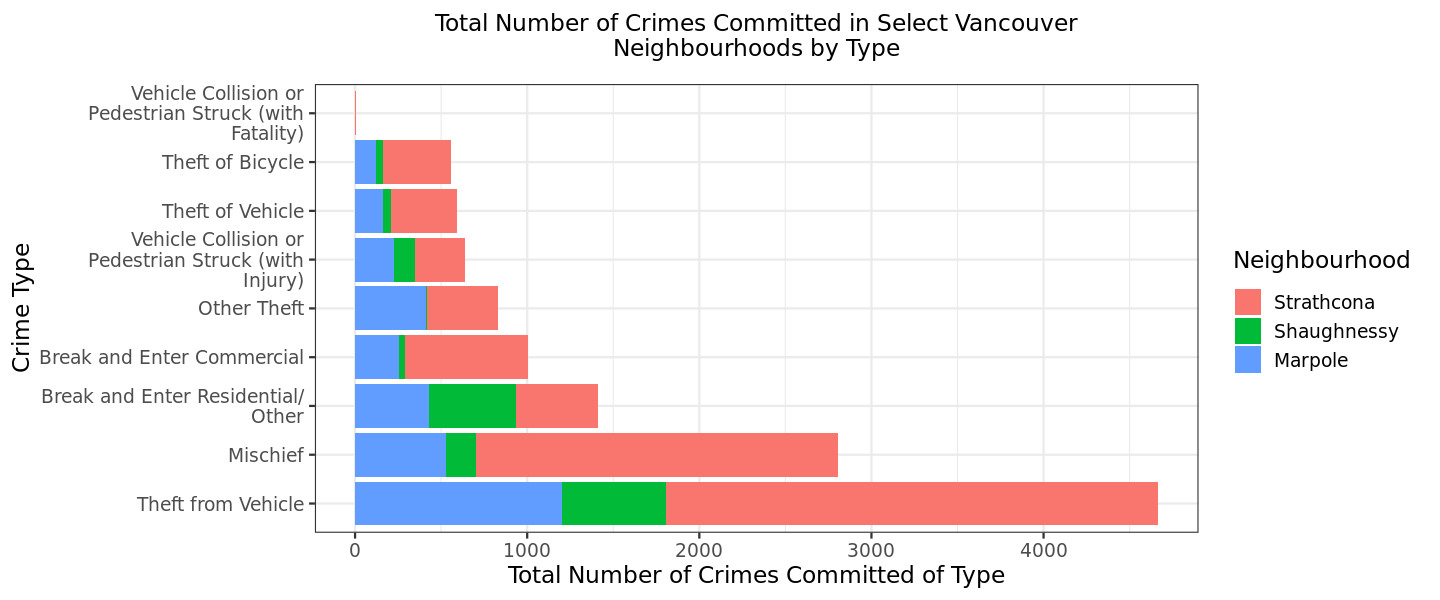

In [18]:
# 2. Note that the stringr::str_wrap call wraps the long label names for crime types, and
# reorder places the largest crime count on the bottom
crime_type_bar_plot <- crime_data %>%
    ggplot(aes(x = reorder(str_wrap(type, 30), type, function(x) - length(x)), fill = neighbourhood)) +
    geom_bar(position = "stack") +
    labs(x = "Crime Type", y = "Total Number of Crimes Committed of Type", fill = "Neighbourhood") +
    ggtitle("Total Number of Crimes Committed in Select Vancouver\nNeighbourhoods by Type\n") +
    coord_flip() +
    theme_stat201()

# Vehicle collisions that result in fatality are (thankfully) very low,
# and almost distinguishable on the plot below                           
crime_type_bar_plot
create_caption(2, "A stacked bar chart depicting the total number of crimes by type and neighbourhood.")

This plot shows that theft from vehicle, in the Strathcona region, makes up a large proportion of all crimes committed. We can also see, thankfully, that vehicle collisions resulting in fatality make up such a small fraction of our data they're hard to distinguish.

Finally, we can look at a visualization of the relative frequencies of crime over the years through a waffle chart. N.B: Each individual square represents 30 items.

In [19]:
# Let's produce a count of the crime by year and type
crime_waffle <- crime_data %>%
    count(year, type) %>%
    mutate(n = n / 30)
head(crime_waffle)
# The geom_waffle() function will do some magic for us in terms of rounding

year,type,n
<dbl>,<fct>,<dbl>
2017,Break and Enter Commercial,7.233333
2017,Break and Enter Residential/Other,11.500000
2017,Mischief,21.500000
2017,Other Theft,7.433333
2017,Theft from Vehicle,37.700000
2017,Theft of Bicycle,4.466667


[1] "Figure #3: A waffle plot depicting the proportion of each crime time by year."


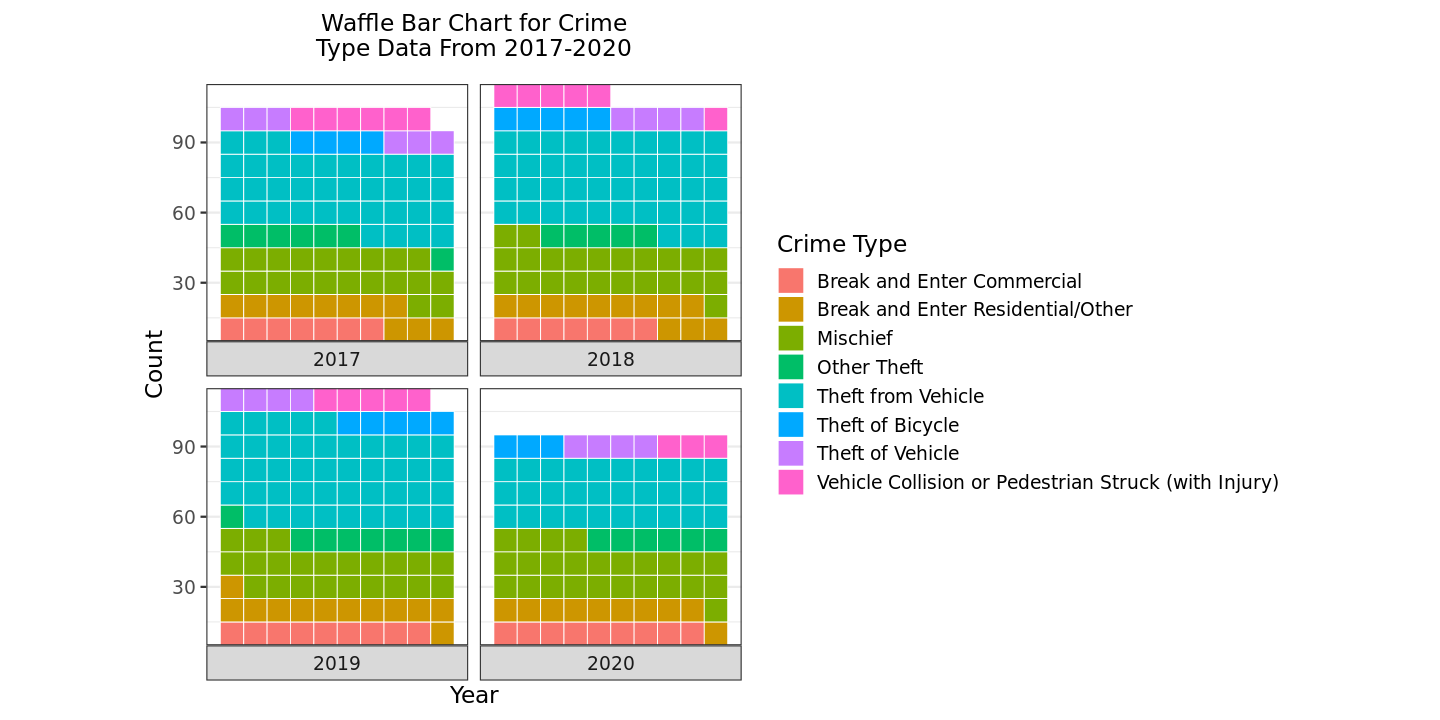

In [20]:
# 3. Let's look at the proportion of each crime committed over the years
waffle_plot <- crime_waffle %>%
    ggplot(aes(values = n, fill = type)) +
    geom_waffle(n_rows = 10, flip = TRUE, color = "white", size = 0.25) +
    facet_wrap(~year, nrow = 2, strip.position = "bottom") +
    scale_x_discrete() + 
    scale_y_continuous(labels = function(x) x * 10, # make this multiplier the same as n_rows
                       expand = c(0,0)) +
    labs(
        title = "Waffle Bar Chart for Crime\nType Data From 2017-2020\n",
        # subtitle = "A single square represents 30 crimes",
        x = "Year",
        y = "Count",
        fill = "Crime Type"
    ) +
    coord_equal() +
    theme_enhance_waffle() +
    theme(legend.position = "bottom") +
    theme_stat201(12, 6)
waffle_plot
create_caption(3, "A waffle plot depicting the proportion of each crime time by year.")

No trends are particularly obvious from the waffle plot, though we can see a clear reduction in crime overall in 2020, and it seems as though it is in large part due to a steep decline in "theft from vehicle" crimes.

Now, we can compute estimates of our parameter of interest across each of our different groups. In our case, this means computing the difference between the mean of the proportion of theft crimes committed across 2017 to 2019 and the proportion of theft crimes committed in 2020.

In [21]:
# Let's first compute the pre-COVID mean in each neighbourhood (merging 2017 to 2019)
before_pandemic_df_by_year <- crime_data %>%
    mutate(is_theft = as.numeric(type %in% theft_crimes)) %>%
    filter(year >= 2017 & year <= 2019) %>%
    group_by(neighbourhood, year) %>%
    summarize(prop_theft = sum(is_theft) / n())
# View prop_theft by year (2017, 2018, 2019) and neighbourhood
# head(p_hat_pre_covid_by_year)

before_pandemic_df <- before_pandemic_df_by_year %>%
    group_by(neighbourhood) %>%
    summarize(prop_theft = mean(prop_theft)) %>%
    mutate(time = "Before pandemic") %>%
    mutate(time = as_factor(time))
head(before_pandemic_df)

`summarise()` has grouped output by 'neighbourhood'. You can override using the `.groups` argument.



neighbourhood,prop_theft,time
<fct>,<dbl>,<fct>
Strathcona,0.5578307,Before pandemic
Shaughnessy,0.4624363,Before pandemic
Marpole,0.5675852,Before pandemic


In [22]:
# Now let's get an estimate for the COVID mean by neighbourhood
during_pandemic_df <- crime_data %>%
    mutate(is_theft = as.numeric(type %in% theft_crimes)) %>%
    filter(year == 2020) %>%
    group_by(neighbourhood) %>%
    summarize(prop_theft = sum(is_theft) / n()) %>%
    mutate(time = "During pandemic") %>%
    mutate(time = as_factor(time))
head(during_pandemic_df)

neighbourhood,prop_theft,time
<fct>,<dbl>,<fct>
Strathcona,0.4385246,During pandemic
Shaughnessy,0.4349030,During pandemic
Marpole,0.5655738,During pandemic


In [23]:
# Summarize in table
prof_diff_df <- during_pandemic_df %>%
    rename(during_prop_theft = prop_theft) %>%
    select(during_prop_theft) %>%
    cbind(before_pandemic_df) %>%
    mutate(prop_diff = during_prop_theft - prop_theft) %>%
    select(neighbourhood, prop_diff)
head(prof_diff_df)

,neighbourhood,prop_diff
,<fct>,<dbl>
1,Strathcona,-0.119306097
2,Shaughnessy,-0.027533295
3,Marpole,-0.002011429


Note that a negative value indicates a _decrease_ in crime during 2020. Our initial data suggests that the proportion of theft-related crime has actually _decreased_ since the pandemic began. While this is a good estimate for us to begin our analysis with, it's by no means sufficient to conclude upon; more as to why that is the case is discussed below.

## Methods

### Strengths

Our report uses data from the Vancouver Police Department to study trends in crime across select Vancouver neighborhoods. It is "trustworthy" in the sense that we will look to be careful at providing _ranges_ of our final answer, rather than solely point estimates. However, that alone isn't enough to guarantee an effective analysis. 

We're also using blocking in our analysis. Crime has been linked to wealth (and more specifically, socioeconomic status, or SES) [[World Bank, 8]](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1745-9125.1999.tb00483.x), so we'll treat it as a blocking variable, and group our data by three neighborhoods that represent different levels of wealth.

Finally, we're being careful to not simply compare the trend of crime between 2019 and 2020. Since our focus is COVID-19, we're not especially interested in the 1-year trend, but rather, how 2020 has deviated from the "norm." It is plausible that 2019 was an outlier, so "merging" the 3-year span of 2017 to 2019 should provide us a better sense of the general, recent crime levels in Vancouver.

### Limitations

Some could argue that many of the "petty" crimes we're interested in, like theft, largely go unreported. And while our analysis does indeed aim to provide an estimate from this sample of strictly reported crimes, arguing what makes a "fair" range is a hard question to answer. Countless factors affect whether or not a crime gets reported, and trust in police generally was found to be at a "record low" in August of 2020 [[New York Times, 10]](https://www.nytimes.com/2020/08/12/us/gallup-poll-police.html). Accounting for this variability, statistically, is arduous.

Furthermore, while our neighborhood selections do represent a fair amount of spread in the wealth of various Vancouver neighborhoods, they're by no means perfectly representative. Shaughnessy, for one, being at a rather high-end extreme of wealth, might be less useful in our analysis, as it doesn't really generalize to any kind of useful population outside of that specific neighborhood.

### Analysis

Of course, the plots and estimates provided above are _not_ sufficient for any stakeholder, such as the municipal government or the VPD themselves. Since we're working with a sample, we must report a range of plausible values, rather than a single point estimate. Thankfully, there are a few steps we can take to do this in different ways:

Firstly, we can produce a hypothesis test, where our null is that theft-related crime rates have _not_ changed:

$$H_0: \Delta{p} = 0$$

and our alternative hypothesis is that there has been some sort of change.

$$H_A: \Delta{p} \ne 0$$

We'll have to do a two-tailed test and check if our sample difference in proportions falls within our significance level. As for what value of $\alpha$ to use, it's hard to say. We'll likely go with something like 10%, since we're working with a social science topic, and thus more variability is generally considered acceptable.

Secondly, we can produce a confidence interval to report a range of plausible values alongside our difference in proportions statistic. We'll use two techniques, both bootstrapping (i.e., generating a bootstrapped sampling distribution) and asymptotics, to yield a range of values at a confidence level ("CL") of 90%, though that value could change as we deem appropriate. 

(Note that two-tailed hypothesis tests are confidence intervals are practically equivalent at ${CL} = 1 - \alpha$, but doing both approaches is good for rigor and completeness, and allows us to use both bootstrapping and asymptotics.)

Along the way, we will be sure to visualize and interpret our results within the context of our problem. These techniques will also allow us to report something actually sufficient for a stakeholder: both a statistic and a range. This is at the core of inferential statistics.

## Reflection

In our final report, we expect to find that the rate of theft-related crime has changed significantly from past years, supporting the hypothesis that the pandemic is correlated to changing crime rates, including at local levels, with petty crimes.

We anticipate the impact of our findings will be the production of actionable insights for both city officials and the VPD. Getting budgets right is hard, but using data-driven methods makes the process significantly easier. Through hypothesis testing, we can put both the safety and security of Vancouverites as a top priority, as weighing police funding versus additional social security measures is of utmost importance.

Three examples of further questions that could extend this analysis are:

1. Have other (perhaps, more small scale) pandemics affected the rate of theft-related crime? A study could be done of SARS in Toronto, from 2003-04.
2. How has COVID-19 affected the rate of theft-related crime at different cities across Canada? Cities could include: Calgary, Edmonton, Winnipeg, Regina, etc.
3. In what ways has the rate of violent crime changed since the pandemic began? We could look at the rate of more intense crimes, still on a city basis.

<hr >

## References

1. Statistics Canada, _The Social and Economic Impacts of COVID-19: A Six-Month Update_. Published October 20, 2020. [Source](https://www150.statcan.gc.ca/n1/pub/11-631-x/2020004/conclusions-eng.htm).

2. Interpol, _Operation Pangea – shining a light on pharmaceutical crime_. Published November 21, 2019. [Source](https://www.interpol.int/en/News-and-Events/News/2019/Operation-Pangea-shining-a-light-on-pharmaceutical-crime).

3. ABC News, _FBI warns of potential surge in hate crimes against Asian Americans amid coronavirus_. Published March 27, 2020. [Source](https://abcnews.go.com/US/fbi-warns-potential-surge-hate-crimes-asian-americans/story?id=69831920).

4. UN News, _UN chief calls for domestic violence ‘ceasefire’ amid ‘horrifying global surge’_. Published April 6, 2020. [Source](https://news.un.org/en/story/2020/04/1061052).

5. CBC, _City of Vancouver freezes police department funding as part of 2021 budget_. Published December 8, 2020. [Source](https://www.cbc.ca/news/canada/british-columbia/city-of-vancouver-freezes-police-department-funding-as-part-of-2021-budget-1.5833731).

6. Vancouver Police Department, _Crime Data_. Accessed March 5, 2021. [Source](https://geodash.vpd.ca/opendata/).

7. Piazza, _Group Project clarification_. Published March 4, 2021. [Source](https://piazza.com/class/kjqe81ynudx2rm?cid=169).*

8. Wright, Bradley R. Entner, Avshalom Caspi et al in Criminology, _RECONSIDERING THE RELATIONSHIP BETWEEN SES AND DELINQUENCY: CAUSATION BUT NOT CORRELATION_. Published March 7, 2006. [Source](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1745-9125.1999.tb00483.x).

9. City of Vancouver, _Census local area profiles 2016_. Published April 10, 2018. [Source](https://opendata.vancouver.ca/explore/dataset/census-local-area-profiles-2016/information/).

10. New York Times, _Confidence in Police Is at Record Low, Gallup Survey Finds_. Published August 12, 2020. [Source](https://www.nytimes.com/2020/08/12/us/gallup-poll-police.html).

11. Wickham, Hadley and Garrett Grolemund, _R for Data Science_. Published December 2016. [Source](https://r4ds.had.co.nz/).

12. Timbers, Tiffany-Anne, Trevor Campbell and Melissa Lee, _Data Science: A First Introduction_. Last updated January 12, 2021. [Source](https://ubc-dsci.github.io/introduction-to-datascience/).

\* Note the Piazza reference is used to ensure we're handling a proportions analysis correctly, since it was a bit unclear in the instructions.

In [24]:
# Delete unzipped files, and the zip archive
unlink("*.csv")
unlink("*.txt")
unlink("*.pdf")
unlink("*.zip")